In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import obonet
import BOCC
import pandas as pd
import numpy as np
import math
import typing
import seaborn as sns
import os


## Plotting Constants

In [2]:
label_size = 16
tick_label_size = 14
panel_number_size = 24
algos = ['paris-greedy','paris-walktrap','paris-infomap','paris-cesna']
colors = ['#f4cccc','#fff2cc','#d9ead3','#a4c2f4']
algos_colors = {x:c for x,c in zip(algos,colors)}

In [3]:
def clear_ax(ax, top=False, bottom=False, left=False, right=False):
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    # ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
    ax.yaxis.set_tick_params(width=0.0, labelsize=8)
    ax.xaxis.set_tick_params(width=0.0, labelsize=8)

## Load data

In [4]:
# load the edgelists as networkx objects
G15 = nx.read_edgelist('../Edgelists/String_HPO_2015.phenotypic_branch.edgelist.txt')
G16 = nx.read_edgelist('../Edgelists/String_HPO_2016.phenotypic_branch.edgelist.txt')
G17 = nx.read_edgelist('../Edgelists/String_HPO_2017.phenotypic_branch.edgelist.txt')
G18 = nx.read_edgelist('../Edgelists/String_HPO_2018.phenotypic_branch.edgelist.txt')

G19 = nx.read_edgelist('../Edgelists/String_HPO_2019.phenotypic_branch.edgelist.txt')
G20 = nx.read_edgelist('../Edgelists/String_HPO_2020.phenotypic_branch.edgelist.txt')
G21 = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')

In [5]:
# load rediscovery stats
g_snow = pd.read_csv('../SnowballResults/snowball.paris.greedy.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
w_snow = pd.read_csv('../SnowballResults/snowball.paris.walktrap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
i_snow = pd.read_csv('../SnowballResults/snowball.paris.infomap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
c_snow = pd.read_csv('../SnowballResults/snowball.paris.cesna.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
print(g_snow.shape)
print(w_snow.shape)
print(i_snow.shape)
print(c_snow.shape)

(182900, 5)
(80400, 5)
(385500, 5)
(2847100, 5)


## Plot network size stats by year

In [6]:
# count node and edge type stats
def count_size_stats(_G):
    # count genes
    num_genes = sum(['HP:' not in n for n in _G.nodes])
    # count HPOs
    num_hpos = sum(['HP:' in n for n in _G.nodes])
    # 0 = p2p, 1 = p2g, 2 = p2p
    hpo_counts = [ sum(['HP:' in x for x in e]) for e in _G.edges]
    # count g2p
    num_g2p = hpo_counts.count(1)
    # count g2g
    num_p2p = hpo_counts.count(2)
    # count p2p
    num_g2g = hpo_counts.count(0)
    return [num_genes, num_hpos, num_p2p, num_g2p, num_g2g]

plt_data = {'year':[],'type':[],'count':[]}
for y,_g in zip(list(range(2015,2022)),[G15,G16,G17,G18,G19,G20,G21]):
    stats = count_size_stats(_g)
    for t,x in zip(['STRING nodes', 'HPO Terms', 'HPO edges', 'gene-2-phenotyoe', 'STRING edges'],stats):
        plt_data['year'].append(y)
        plt_data['type'].append(t)
        plt_data['count'].append(x)
plt_df = pd.DataFrame(plt_data)

                                        

<Figure size 1080x1080 with 0 Axes>

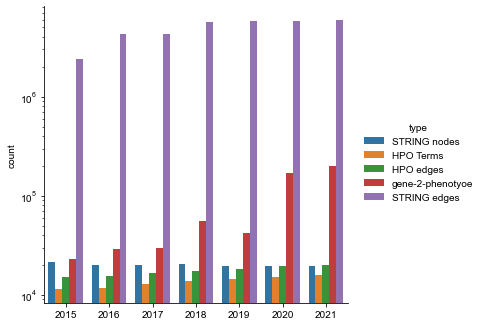

In [7]:
plt.figure(figsize = (15,15))
g=sns.catplot(
    data=plt_df, kind="bar",
    x="year", y="count", hue="type",
    ci="sd")
sns.set(rc={'figure.figsize':(15,15)})
g.set(yscale='log',xlabel='', facecolor='white')
plt.savefig('../Figures/yearly_stats.jpg',dpi=300)


In [8]:
print(plt_df[plt_df['type'] == 'gene-2-phenotyoe'])

    year              type   count
3   2015  gene-2-phenotyoe   22810
8   2016  gene-2-phenotyoe   29196
13  2017  gene-2-phenotyoe   29654
18  2018  gene-2-phenotyoe   56380
23  2019  gene-2-phenotyoe   42079
28  2020  gene-2-phenotyoe  170892
33  2021  gene-2-phenotyoe  197926


## Calculate Log2Ratio and empirical p-value for each cluster in each algo

In [9]:
l2r_p = {'algorith':[],'cluster_id':[],'log2ratio':[],'p-value':[]}

def log_2_ratio(o: int, e: typing.List[int]) -> float:
    """
    param o: observed number of rediscoveries
    param e: list of expected number of rediscoveries based on the null model
    """
    return float(np.log2(o / np.median(np.array(e))))

def empircal_p(o: int, e: typing.List[int]) -> float:
    """
    param o: observed number of rediscoveries
    param e: list of expected number of rediscoveries based on the null model
    """
    return float(1 - (sum([ o > x for x in e]) / len(e)))

# test the functions
assert(log_2_ratio(2,[2,2,2]) == 0)
assert(log_2_ratio(2,[1,1,1]) > 0)
assert(log_2_ratio(2,[3,3,3]) < 0)
assert(empircal_p(2,[2,2,2]) == 1)
assert(empircal_p(2,[1,1,1]) == 0)
assert(round(empircal_p(2,[3,1,1]),2) == round(float(1/3),2))

# calc log2ratio and p value for each cluster in each algo category. Save it all in one dataframe
for df,algo in zip([g_snow, w_snow, i_snow, c_snow],algos):
    for cid in df['com_id'].unique():
        sub = df[df['com_id'] == cid]
        observed = list(sub['com_score'])[0]
        expected = list(sub['replicate_score'])
        l2r = log_2_ratio(observed,expected)
        p = empircal_p(observed,expected)
        l2r_p['algorith'].append(algo)
        l2r_p['cluster_id'].append(cid)
        l2r_p['log2ratio'].append(l2r)
        l2r_p['p-value'].append(p)
l2r_p_df = pd.DataFrame(l2r_p)
print(l2r_p_df.columns)
print(l2r_p_df.shape)

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_58009/379432370.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_58009/379432370.py:8: RuntimeWarning: divide by zero encountered in log2
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_58009/379432370.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))


Index(['algorith', 'cluster_id', 'log2ratio', 'p-value'], dtype='object')
(34959, 4)


## Plot Log-2-Ratio vs P-Value

Log-2-ratio non inf max and min 10.59245703726808 -4.129283016944966
paris-greedy
number of infs 178 , 0.09732094040459267
number of -infs 332 , 0.1815199562602515
% r > 0 19.35483870967742 %
p < .0001 1.9682886823400765 %
paris-walktrap
number of infs 50 , 0.06218905472636816
number of -infs 169 , 0.21019900497512436
% r > 0 11.442786069651742 %
p < .0001 2.8606965174129355 %
paris-infomap
number of infs 137 , 0.035538261997405965
number of -infs 924 , 0.2396887159533074
% r > 0 6.511024643320364 %
p < .0001 0.9079118028534372 %
paris-cesna
number of infs 1962 , 0.06891222647606336
number of -infs 5990 , 0.21038951915984686
% r > 0 8.29264866004004 %
p < .0001 2.700993993888518 %


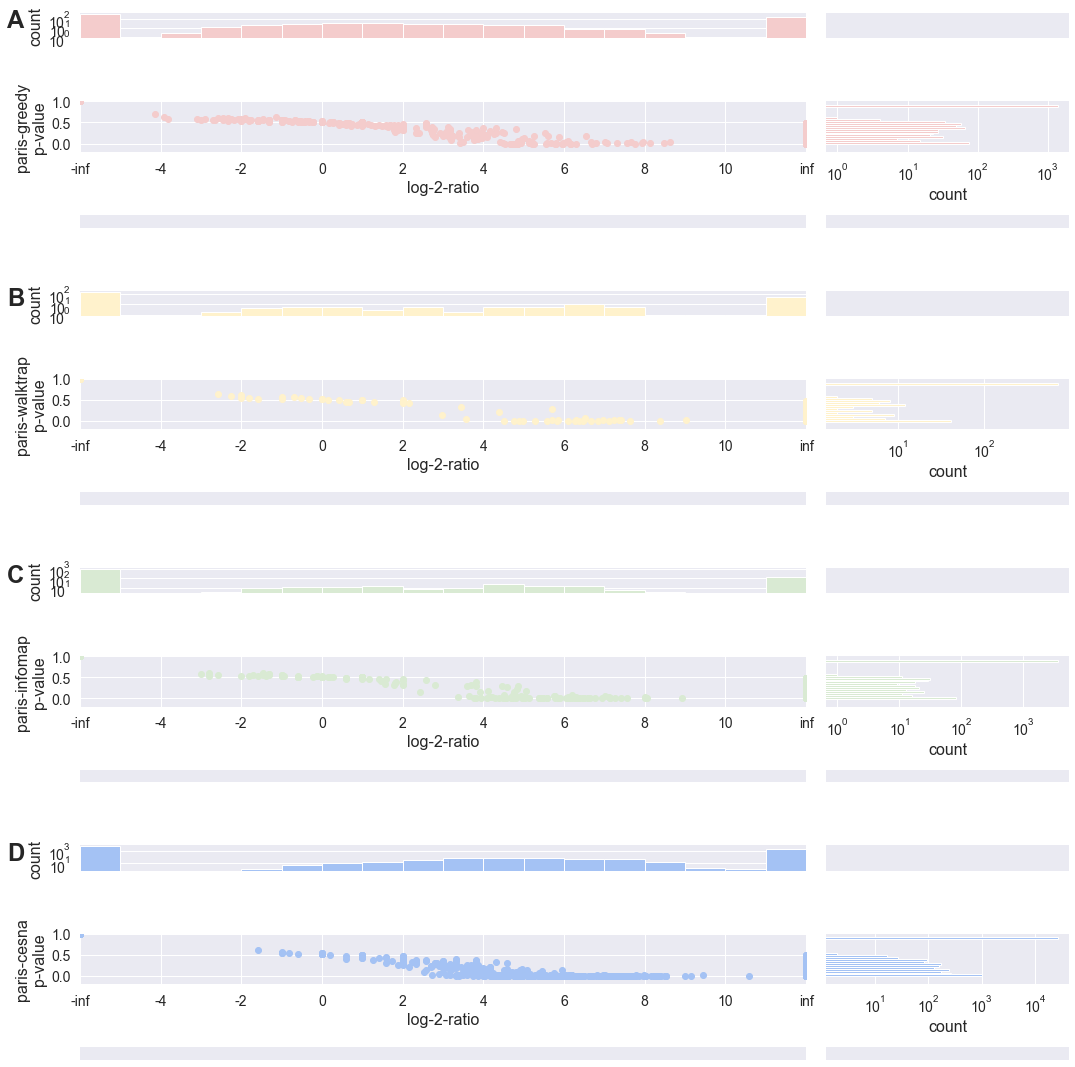

In [10]:
# plot
# for each algo
l2r_p_df = pd.DataFrame(l2r_p)
l2r_p_df = l2r_p_df.sort_values('log2ratio',ascending=False)
arr = l2r_p_df['log2ratio']
l2r_min = np.nanmin(arr[arr != -np.inf])
l2r_max = np.nanmax(arr[arr != np.inf])
print('Log-2-ratio non inf max and min', l2r_max, l2r_min)

# replace INF with 12 (well above the next largest value) and -INF -7 (well below the next lowest)
inf_replacement = 12
neg_inf_replacement = -6    
l2r_p_df['log2ratio'] = [inf_replacement if x == np.inf else x for x in l2r_p_df['log2ratio']]
l2r_p_df['log2ratio'] = [neg_inf_replacement if x == -np.inf else x for x in l2r_p_df['log2ratio']]

# create figure and axes objects
fig, axes = plt.subplots(12,2,gridspec_kw={'width_ratios': [3, 1],'height_ratios': [2, 4, 1, 2, 4, 1, 2, 4, 1, 2, 4, 1]})
fig.set_size_inches(15, 15)

# remove borders and ticks of plots that should be blank space
for i in range(0,12):
    for j in range(2):
        clear_ax(axes[i][j])
        if i % 3 == 0 and j == 1 or i in [2,5,8,11]:
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])

# labels for plot panels
labels = ['A','B','C','D']
for i,algo in enumerate(algos):
    print(algo)
    # establish proper indexes for histograms and scatter plots
    hist_i = i * 3
    scat_i = hist_i + 1
    
    # sub set the df for just this algo
    sub = l2r_p_df[l2r_p_df['algorith'] == algo]
    print('number of infs',sum(sub['log2ratio'] == inf_replacement), ',', sum(sub['log2ratio'] == inf_replacement) / sub.shape[0] )
    print('number of -infs',sum(sub['log2ratio'] == neg_inf_replacement), ',', sum(sub['log2ratio'] == neg_inf_replacement) / sub.shape[0])
    print('% r > 0', (sum(sub['log2ratio'] > 0) / sub.shape[0]) * 100, '%')
    print('p < .0001', (sum(sub['p-value'] <= 0.0001) / sub.shape[0]) * 100, '%' )
    # scatter
    axes[scat_i][0].scatter(sub['log2ratio'],sub['p-value'],c = algos_colors[algo])
    axes[scat_i][0].set_xlim(neg_inf_replacement,inf_replacement)
    # set the x tick and artificially add
    axes[scat_i][0].set_xticks([neg_inf_replacement,-4,-2,0,2,4,6,8,10,inf_replacement])
    axes[scat_i][0].set_xticklabels(['-inf',-4,-2,0,2,4,6,8,10,'inf'])
    axes[scat_i][0].set_ylim(-.2,1)
    axes[scat_i][0].set_ylabel('{}\np-value'.format(algo),size=label_size)
    axes[scat_i][0].set_yticks([0,.5,1])
    axes[scat_i][0].set_xlabel('log-2-ratio',size=label_size)
    axes[scat_i][0].tick_params(axis='both', which='major', labelsize=tick_label_size)
    
    # X hist - above
    hist_bins = axes[hist_i][0].hist(sub['log2ratio'],
                                     bins=np.arange(neg_inf_replacement, inf_replacement + 1, 1),
                                     orientation='vertical',
                                     color = algos_colors[algo])
    axes[hist_i][0].set_xlim(neg_inf_replacement,inf_replacement)
    axes[hist_i][0].set_xticks([])
    axes[hist_i][0].set_yscale('log')
    axes[hist_i][0].set_ylabel('count',size=label_size)
    axes[hist_i][0].tick_params(axis='both', which='major', labelsize=tick_label_size)
    
    # Panel label
    axes[hist_i][0].text(-0.1, 1.15, labels[i], transform=axes[hist_i][0].transAxes,
      fontsize=panel_number_size, fontweight='bold', va='top')
    
    # X hist - right
    axes[scat_i][1].hist(sub['p-value'],bins=20,orientation='horizontal',color = algos_colors[algo])
    axes[scat_i][1].set_ylim(-.2,1.1)
    axes[scat_i][1].set_xscale('log')
    axes[scat_i][1].set_yticks([])
    axes[scat_i][1].set_xlabel('count',size=label_size)
    axes[scat_i][1].tick_params(axis='both', which='major', labelsize=tick_label_size)

plt.tight_layout()
plt.savefig('../Figures/log_vs_p_19v20.png',dpi=300)
plt.show()

In [11]:
# print(np.log2())
print(c_snow.columns)
aa = c_snow[c_snow['com_id'] == 21364]
print(aa)
print(log_2_ratio(list(aa['com_score'])[0],list(aa['replicate_score'])))
temp_o = list(aa['com_score'])[0]
temp_e = list(aa['replicate_score'])
print('O=',temp_o)
print('E=',np.median(np.array(temp_e)))
# float(np.log2(temp_o / np.median(np.array(temp_e))))
print('Neg Inf')
aa = c_snow[c_snow['com_id'] == 18210]
print(aa)
print(log_2_ratio(list(aa['com_score'])[0],list(aa['replicate_score'])))
temp_o = list(aa['com_score'])[0]
temp_e = list(aa['replicate_score'])
print('O=',temp_o)
print('E=',np.median(np.array(temp_e)))
print(np.log2(temp_o / 10))
l2r_p_df['p-value']

Index(['com_id', 'com_score', 'replicate_id', 'replicate_score',
       'rep_and_com_size'],
      dtype='object')
         com_id  com_score  replicate_id  replicate_score  rep_and_com_size
2136400   21364        538             0               74                42
2136401   21364        538             1                0                42
2136402   21364        538             2                0                42
2136403   21364        538             3               44                42
2136404   21364        538             4               36                42
...         ...        ...           ...              ...               ...
2136495   21364        538            95                0                42
2136496   21364        538            96                0                42
2136497   21364        538            97                0                42
2136498   21364        538            98               28                42
2136499   21364        538            99         

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_58009/379432370.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_58009/379432370.py:8: RuntimeWarning: divide by zero encountered in log2
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_58009/1168395686.py:19: RuntimeWarning: divide by zero encountered in log2
  print(np.log2(temp_o / 10))


27852    0.00
27450    0.45
10270    0.40
10272    0.00
10280    0.02
         ... 
34952    1.00
34954    1.00
34955    1.00
34957    1.00
34958    1.00
Name: p-value, Length: 34959, dtype: float64

## Edge Uniqueness

In [23]:
g2p_edges_2021 = [e for e in G21.edges if sum('HP:' in x for x in e) == 1 and e not in G20.edges]
print(len(g2p_edges_2021))
# get a list of rediscoveries per algo
def rediscover(edges,coms):
    """
    @param edges: list of edges [[node1,node2],[node1,node3],..]
    @param coms: list of BOCC objects
    """
    rediscoveries = list()
    for com in coms:
        for edge in edges:
            edge = list(edge)
            if edge[0] in com.members and edge[1] in com.members:
                edge.sort()
                rediscoveries.append(str(edge))
                print(com.name,edge)
    return rediscoveries


31858


In [ ]:
clusters_dict_2020 = {}
for f in os.listdir('../SubComs/2020/'):
    if 'paris' not in f:
        continue
    tmp_coms = BOCC.load_clusters('../SubComs/2020/' + f)
    tmp_name = f.replace('.coms.txt','')
    rediscover(g2p_edges_2021,tmp_coms)
    clusters_dict_2020[tmp_name] = rediscover(g2p_edges_2021,tmp_coms)
    print(tmp_name)
    print(len(clusters_dict_2020[tmp_name]))

In [ ]:
# calc data for uniqueness
uniq_rediscovery = {'algo':[],'infotype':[],'count':[]}
# all_rediscoveries = list()
# for key in rediscovery_res.keys():
#     all_rediscoveries = all_rediscoveries + rediscovery_res[key]
# all_rediscoveries_set = set(all_rediscoveries)

for key in clusters_dict_2020.keys():
    all_rediscoveries = list()
    for key2 in clusters_dict_2020.keys():
        if key == key2:
            continue
        all_rediscoveries = all_rediscoveries + clusters_dict_2020[key2]
    
    all_rediscoveries_set = set(all_rediscoveries)
    print(len(all_rediscoveries_set))
    print(key)
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('total')
    uniq_rediscovery['count'].append(len(clusters_dict_2020[key]))
    
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('total unique self')
    uniq_rediscovery['count'].append(len(set(clusters_dict_2020[key])))
    
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('common')
    uniq_rediscovery['count'].append(len([x for x in set(clusters_dict_2020[key]) if x in all_rediscoveries_set]))
    
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('unique')
    uniq_rediscovery['count'].append(len([x for x in set(clusters_dict_2020[key]) if x not in all_rediscoveries_set]))

uniq_rediscovery_df = pd.DataFrame(uniq_rediscovery)
print(uniq_rediscovery_df.shape)
assert(uniq_rediscovery_df.shape[0] == 4 * 4)

In [ ]:
# plot it
print(uniq_rediscovery_df)
print('unique:',sum(uniq_rediscovery_df[uniq_rediscovery_df['infotype'] == 'unique']['count']))
print('total unique self:',sum(uniq_rediscovery_df[uniq_rediscovery_df['infotype'] == 'total unique self']['count']))
print('common:',sum(uniq_rediscovery_df[uniq_rediscovery_df['infotype'] == 'common']['count']))
sns.barplot(data=uniq_rediscovery_df,x='algo',y='count',hue='infotype')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.savefig('../Figures/2021_rediscovery_on_2020_uniqness.jpg', dpi=300)
plt.show()

## HPO to Gene Edges Infered from MPO

In [25]:
hpo_from_mpo = pd.read_csv('../Resources/hpo_to_gene_derived_by_mpo.edgelist.2021.unique.txt',sep='\t',header=None)
print(hpo_from_mpo)
hpo_from_mpo.columns = ['HPO','Gene','Name']

             0       1                                     2
0   HP:0000086  FANCD2                        Ectopic kidney
1   HP:0000093    G6PC                           Proteinuria
2   HP:0000097    G6PC    Focal segmental glomerulosclerosis
3   HP:0000105    G6PC                       Enlarged kidney
4   HP:0000238    MSH2                         Hydrocephalus
..         ...     ...                                   ...
80  HP:0011463     XPC                       Childhood onset
81  HP:0012213    G6PC  Decreased glomerular filtration rate
82  HP:0020073    MSH2                  Hypopigmented macule
83  HP:0030052    MSH2                    Inguinal freckling
84  HP:0100697    MSH2                     Neurofibrosarcoma

[85 rows x 3 columns]


In [26]:
hpo_mpo_edges = [[row['HPO'],row['Gene']] for i,row in hpo_from_mpo.iterrows()]
hpo_mpo_clusters_dict_2021 = {}
all_new_mpo_edges = []
for f in os.listdir('../SubComs/2021/'):
    if 'paris' not in f:
        continue
    tmp_coms = BOCC.load_clusters('../SubComs/2021/' + f)
    tmp_name = f.replace('.coms.txt','')
    hpo_mpo_clusters_dict_2021[tmp_name] = rediscover(hpo_mpo_edges,tmp_coms)
    print(tmp_name)
    print(len(hpo_mpo_clusters_dict_2021[tmp_name]))
#     print(hpo_mpo_clusters_dict_2021[tmp_name])
    all_new_mpo_edges = all_new_mpo_edges + hpo_mpo_clusters_dict_2021[tmp_name]

print(set(all_new_mpo_edges))
print(len(set(all_new_mpo_edges)))

1309 ['HP:0000979', 'ITGB3']
1309 ['HP:0001892', 'ITGB3']
paris.walktrap.2021
2
1697 ['HP:0004813', 'ITGB3']
1828 ['FANCD2', 'HP:0000086']
paris.infomap.2021
2
956 ['HP:0000979', 'ITGB3']
956 ['HP:0001892', 'ITGB3']
paris.greedy.2021
2
14597 ['HP:0001263', 'TDGF1']
22354 ['FANCD2', 'HP:0000086']
paris.cesna.2021
2
{"['HP:0001892', 'ITGB3']", "['HP:0000979', 'ITGB3']", "['HP:0004813', 'ITGB3']", "['HP:0001263', 'TDGF1']", "['FANCD2', 'HP:0000086']"}
5
